# Generate ROC charts for Gradient Boosted Model
---
Using the parameters from the grid search results with the highest quadratic weighted kappa score, create AUC-ROC charts and investigate the differences between the OvR and OvO methods to binarize multi-class classification models.

In [1]:
import os
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, cohen_kappa_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score

import time

from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
# The 'ID' feature is already dropped from cleaning notebook

# Open all source files as a pd dataframe
# This dataset will be used to train the gradient boosted model
orig_train = pd.read_csv('https://project4-wine-quality-2023.s3.us-west-2.amazonaws.com/train.csv')

#This dataset will be used to evaluate again the Kaggle compitition entry submission
orig_test = pd.read_csv('https://project4-wine-quality-2023.s3.us-west-2.amazonaws.com/test.csv')

# Addition datasets to explore the GradBoost model on actual wine data
# red_data = pd.read_csv('https://raw.githubusercontent.com/Nicholas-Simpson/Project-4/main/gradient_boost/cleaned_data/red_white_data_noID.csv')
# white_data = pd.read_csv('https://raw.githubusercontent.com/Nicholas-Simpson/Project-4/main/gradient_boost/cleaned_data/white_data_noID.csv')
# red_white_data = pd.read_csv('https://raw.githubusercontent.com/Nicholas-Simpson/Project-4/main/gradient_boost/cleaned_data/red_white_data_noID.csv')
# trainable_data = pd.read_csv('https://raw.githubusercontent.com/Nicholas-Simpson/Project-4/main/gradient_boost/cleaned_data/trainable_data_noID.csv')

# Drop 'ID' columns
orig_test = orig_test.drop(columns='Id')
orig_train = orig_train.drop(columns='Id')

# Create a place to save any generated files
gb_roc_output_path = os.path.join('../grad boost output','ROC_AUC')
os.makedirs(gb_roc_output_path, exist_ok = True)

In [4]:
#-------------------------------
#
stratification_method = 'st_skf' # Choose 'none', 'st', 'skf', 'st_skf'  st = stratify split, skf = cross-validation with stratified k-fold, st_skt = both st and skf
#
#-------------------------------

In [5]:
# Split the data into training and testing sets
X_train = orig_train.drop('quality', axis=1)
y_train = orig_train['quality'].copy()
X_test = orig_test.copy()
quality_rating = list(y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  stratify= quality_rating,
                                                  test_size = 0.2, 
                                                  random_state = 42) #because it is the answer :)

# Define Models based on Previous Parameter Grid Searches
Define the models using the parameters that provided the highest quadratic kappa score

In [16]:
# Create a Gradient Boosting Regressor
model = GradientBoostingClassifier()

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [30],
    'learning_rate': [0.05],
    'max_depth': [2]
}

# Use stratified k-fold cross-validation
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search with cross-validation
start_time = time.time()
grid_search = GridSearchCV(model, param_grid, cv=skfold, verbose=3)
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_gb = grid_search.best_estimator_
grid_search_time = time.time()

# Make predictions on the test data using the best model
y_pred = best_gb.predict(X_val)
y_score = best_gb.predict_proba(X_val) # this line is needed to create ROC charts

# Report how long it took to complete Grid search and prediction
end_time = time.time()
grid_time = grid_search_time - start_time
pred_time = end_time - grid_search_time
tot_time = end_time - start_time


print("--------------------------------------------------------------------------------------------------")
print()
print(f"Time to complete Grid Search: {grid_time:.6f} seconds")
print(f"Time to complete prediction: {pred_time:.6f} seconds")
print(f"Total time to complete Grid Search and prediction: {tot_time:.6f} seconds")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END learning_rate=0.05, max_depth=2, n_estimators=30;, score=0.565 total time=   0.4s
[CV 2/5] END learning_rate=0.05, max_depth=2, n_estimators=30;, score=0.565 total time=   0.4s
[CV 3/5] END learning_rate=0.05, max_depth=2, n_estimators=30;, score=0.590 total time=   0.4s
[CV 4/5] END learning_rate=0.05, max_depth=2, n_estimators=30;, score=0.623 total time=   0.4s
[CV 5/5] END learning_rate=0.05, max_depth=2, n_estimators=30;, score=0.561 total time=   0.4s
--------------------------------------------------------------------------------------------------

Time to complete Grid Search: 2.364726 seconds
Time to complete prediction: 0.004697 seconds
Total time to complete Grid Search and prediction: 2.369423 seconds


In [17]:
# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
# the following metrics need to include the average type since the validation is ordinal and not binary
f1 = f1_score(y_val, y_pred, average= 'weighted')
precision = precision_score(y_val, y_pred, average= 'weighted')
recall = recall_score(y_val, y_pred, average= 'weighted')
kappa = cohen_kappa_score(y_val, y_pred, weights='quadratic')

print(f"Model scores with stratify and skf:")
print("-------------------")
print(f"Best Estimators: {best_gb.n_estimators}")
print(f"Best Learning Rate: {best_gb.learning_rate}")
print(f"Best Max Depth: {best_gb.max_depth}")
print(f"Accuracy: {accuracy:.2f}")
print(f"F1: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Cohen Kappa Score, quadratic weighted: {kappa:.4f}")

Model scores with stratify and skf:
-------------------
Best Estimators: 30
Best Learning Rate: 0.05
Best Max Depth: 2
Accuracy: 0.62
F1: 0.60
Precision: 0.60
Recall: 0.62
Cohen Kappa Score, quadratic weighted: 0.5528


# Summary Reports
* Defined parameters
* Classification report
* Quadtratic weighted kappa score
* Time to run model

In [18]:
print("--------------------------------------------------------")
print(f"Gradient Boost Model with stratify and statified k-fold activated:")
print(f"     Learning Rate =   {best_gb.learning_rate}")
print(f"     Number of Trees = {best_gb.n_estimators}")
print(f"     Max Tree Depth =  {best_gb.max_depth}")
print("--------------------------------------------------------")
print(f"Classification Report")
print(classification_report(y_val,y_pred))
print("--------------------------------------------------------")
print(f"Quadratic Weighted Kappa Score: {kappa:.4f}")
print("--------------------------------------------------------")
print()
print(f"Time to complete run model: {grid_time:.6f} seconds")
print(f"Time to complete prediction: {pred_time:.6f} seconds")
print(f"Total time to complete model and prediction: {tot_time:.6f} seconds")
print()
print("--------------------------------------------------------")

--------------------------------------------------------
Gradient Boost Model with stratify and statified k-fold activated:
     Learning Rate =   0.05
     Number of Trees = 30
     Max Tree Depth =  2
--------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.71      0.72      0.72       168
           6       0.55      0.69      0.61       156
           7       0.58      0.42      0.49        67
           8       0.00      0.00      0.00         8

    accuracy                           0.62       412
   macro avg       0.31      0.30      0.30       412
weighted avg       0.60      0.62      0.60       412

--------------------------------------------------------
Quadratic Weighted Kappa Score: 0.5528
--------------------------------------------------------

Time to complete run 

# Generate ROC Charts
Using the model results above, generate area under the curve (AUC) ROC charts with the OvR and OvO multi-class binarization stratagies.
* Reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [19]:
# Below this cell content from"
# https://github.com/vinyluis/Articles/blob/main/ROC%20Curve%20and%20ROC%20AUC/ROC%20Curve%20-%20Multiclass.ipynb
def calculate_tpr_fpr(y_val, y_pred):
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_val, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr  # tpr: The True Positive Rate of the classifier /  fpr: The False Positive Rate of the classifier

def get_all_roc_coordinates(y_val, y_pred):
    
    # Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a threshold for the predicion of the class.  
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_pred)):
        threshold = y_pred[i]
        y_predict = y_pred >= threshold
        tpr, fpr = calculate_tpr_fpr(y_val, y_predict)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
         
    return tpr_list, fpr_list   # tpr_list: The list of TPRs representing each threshold.  /   fpr_list: The list of FPRs representing each threshold.


def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    
    # Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    # Args:
    #     tpr: The list of TPRs representing each coordinate.
    #     fpr: The list of FPRs representing each coordinate.
    #     scatter: When True, the points used on the calculation will be plotted with the line (default = True).
     
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, color = 'darkorange',ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

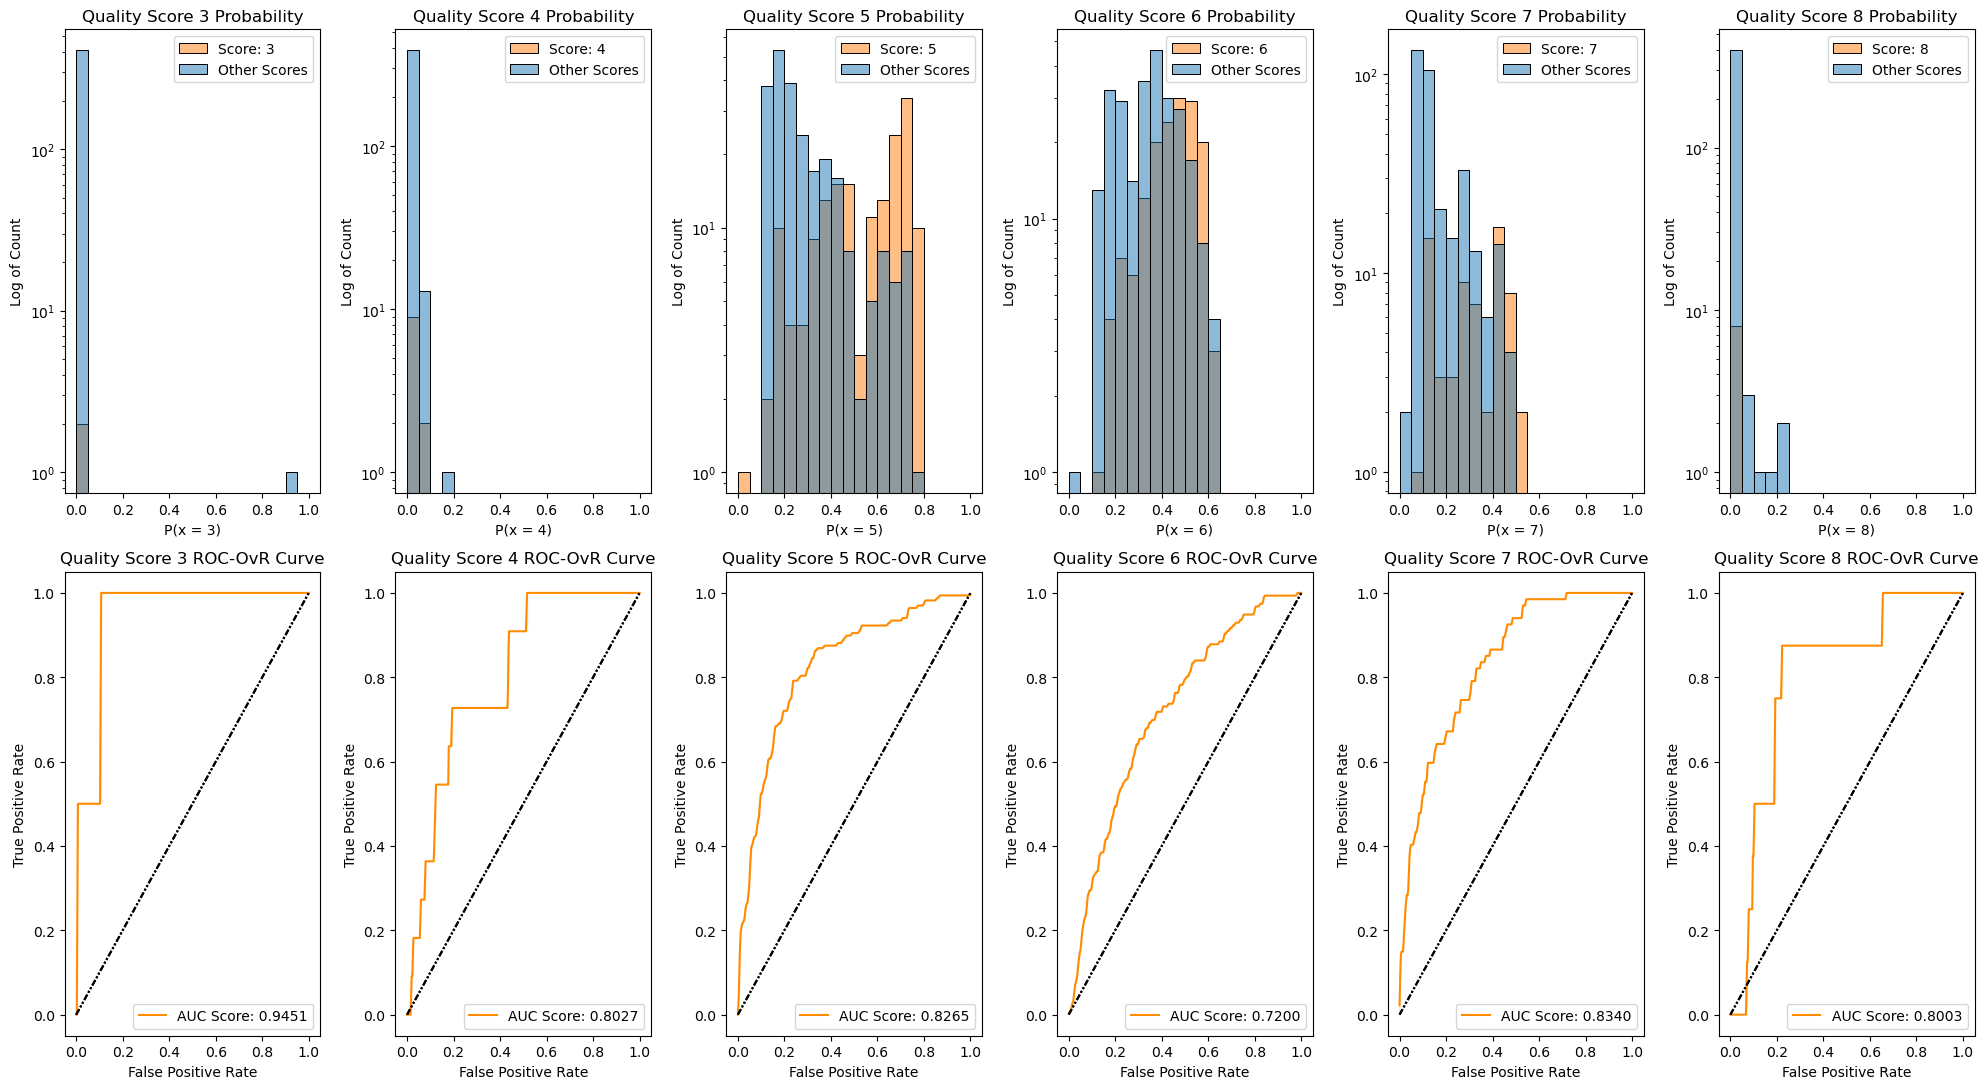

In [20]:
# Plots the Probability Distributions and the ROC Curves One vs Rest
plt.figure(figsize = (20, 11))
bins = [i/20 for i in range(20)] + [1]
classes = best_gb.classes_
roc_auc_ovr = {}
for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    
    # Prepares an helper dataframe to generate plots
    # converts multi class into binary c onfusion matrix to calculate fpr and tpr
    df_aux = X_val.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_val]
    df_aux['prob'] = y_score[:, i]
    df_aux = df_aux.reset_index(drop = True)

    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, len(classes) , i+1) # generate plots in a grid of 2 rows and as many columns as classes starting in row 1 (+1 because it is zero based)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'darkorange', ax = ax, bins = bins)
    ax.set_title(f"Quality Score {c} Probability")
    ax.set_yscale("log")
    ax.legend([f"Score: {c}", "Other Scores"])
    ax.set_xlabel(f"P(x = {c})")
    ax.set_ylabel("Log of Count")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, len(classes), i+len(classes)+1) # i+len(classes)+1 will make a new plot on the next row so it will not overlay on the histograms 
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)

    plt.plot([[0, 0],[1, 1]], color = 'black', linestyle = (0, (3, 1, 1, 1, 1, 1)), label ="Chance level (AUC: 0.5)") # draws line from (0,0) to (1,1) to show AUC score 0.5 (i.e. pure chance)
    ax_bottom.set_title(f"Quality Score {c} ROC-OvR Curve")
    ax_bottom.legend([f"AUC Score: {roc_auc_ovr[c]:.4f}"],loc = 'lower right')
        
plt.tight_layout()

# Save and show the figure
output_filename = f"{gb_roc_output_path}/ROC-OvR_{stratification_method} kappa={kappa:.4f} est:{best_gb.n_estimators} LR:{best_gb.learning_rate} depth:{best_gb.max_depth}.png"
plt.savefig(output_filename)
plt.show()

In [21]:
roc_auc_ovr_df = pd.DataFrame(list(roc_auc_ovr.items()), columns=['OvO', 'AUC-score'])
roc_auc_ovr_df
output_filename = f"{gb_roc_output_path}/ROC-OvR_{stratification_method} kappa={kappa:.4f} est:{best_gb.n_estimators} LR:{best_gb.learning_rate} depth:{best_gb.max_depth}.csv"
roc_auc_ovr_df.to_csv(output_filename, index = False)

## One versus One (OvO) comparison
Recycle/modify the code above to generate the OvO ROC curve and calculate the area under the curve (AUC)

In [22]:
# Create all of the comparisons for OvO analysis
# Note: in the [m,n] pair, m= correct answer and n= incorrect answer. So the pair [m,n] is not the same as [n,m] for the OvO comparison

classes_combo = []
class_list = list(classes)
for i in range(len(class_list)):
    for j in range(i+1, len(class_list)):
        classes_combo.append([class_list[i], class_list[j]])
        classes_combo.append([class_list[j], class_list[i]])


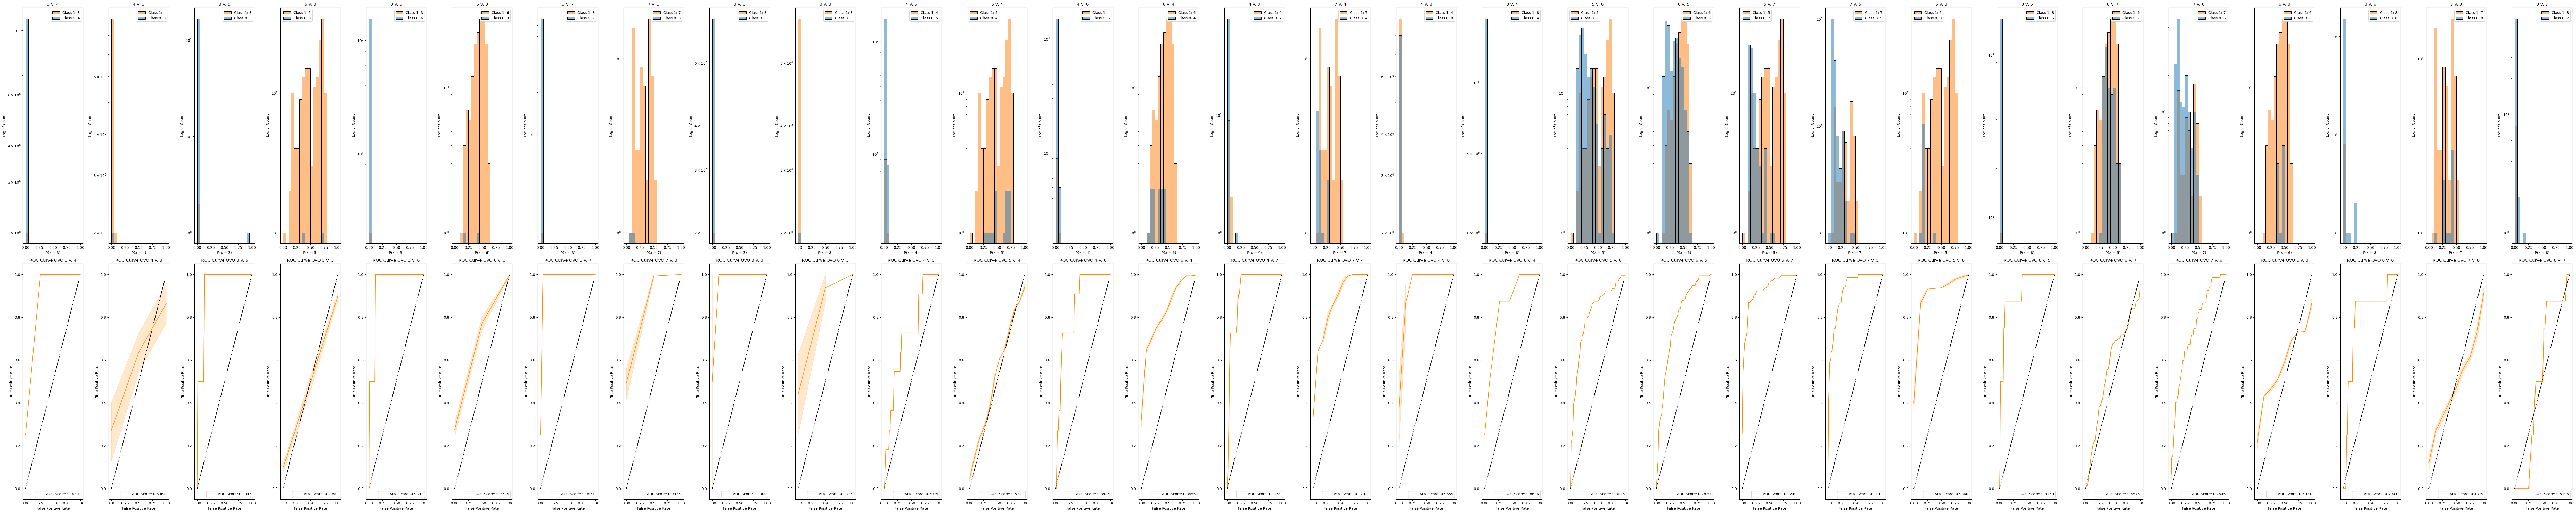

In [23]:
# Plots the Probability Distributions and the ROC Curves One vs ONe
plt.figure(figsize = (100, 20))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovo = {}

for i in range(len(classes_combo)):
    # Gets the class
    comb = classes_combo[i]
    c1 = comb[0]
    c2 = comb[1]
    c1_index = class_list.index(c1)
    title = f"{c1} v. {c2}"
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_val.copy()
    df_aux['class'] = y_val
    df_aux['prob'] = y_score[:, c1_index]
    
    # Slices only the subset with both classes
    df_aux = df_aux[(df_aux['class'] == c1) | (df_aux['class'] == c2)]
    df_aux['class'] = [1 if y == c1 else 0 for y in df_aux['class']]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, len(classes_combo), i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'darkorange', ax = ax, bins = bins)
    ax.set_title(title)
    ax.set_yscale("log") ## Is a log scale needed? A: Yes, to visulaize the small histogram gounts
    ax.legend([f"Class 1: {c1}", f"Class 0: {c2}"])
    ax.set_xlabel(f"P(x = {c1})")
    ax.set_ylabel("Log of Count") ## Is a log scale needed? A: Yes, just as above

    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, len(classes_combo) , i+len(classes_combo)+1)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title(f"ROC Curve OvO {c1} v. {c2}")
    
    # Calculates the ROC AUC OvO
    roc_auc_ovo[title] = roc_auc_score(df_aux['class'], df_aux['prob'])
    plt.plot([[0, 0],[1, 1]], color = 'black', linestyle = (0, (3, 1, 1, 1, 1, 1)), label ="Chance level (AUC: 0.5)") # draws line from (0,0) to (1,1) to show AUC score 0.5 (i.e. pure chance)
    ax_bottom.legend([f"AUC Score: {roc_auc_ovo[f'{c1} v. {c2}']:.4f}"],loc = 'lower right')
    
plt.tight_layout()

# Save and show the figure
output_filename = f"{gb_roc_output_path}/ROC-OvO_{stratification_method} kappa={kappa:.4f} est:{best_gb.n_estimators} LR:{best_gb.learning_rate} depth:{best_gb.max_depth}.png"
plt.savefig(output_filename)
plt.show()

In [24]:
# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovo:
    avg_roc_auc += roc_auc_ovo[k]
    i += 1
    print(f"{k} ROC AUC OvO: {roc_auc_ovo[k]:.4f}")

print(f"average ROC AUC OvO: {avg_roc_auc/i:.4f}")

3 v. 4 ROC AUC OvO: 0.9091
4 v. 3 ROC AUC OvO: 0.6364
3 v. 5 ROC AUC OvO: 0.9345
5 v. 3 ROC AUC OvO: 0.4940
3 v. 6 ROC AUC OvO: 0.9391
6 v. 3 ROC AUC OvO: 0.7724
3 v. 7 ROC AUC OvO: 0.9851
7 v. 3 ROC AUC OvO: 0.9925
3 v. 8 ROC AUC OvO: 1.0000
8 v. 3 ROC AUC OvO: 0.9375
4 v. 5 ROC AUC OvO: 0.7075
5 v. 4 ROC AUC OvO: 0.5241
4 v. 6 ROC AUC OvO: 0.8485
6 v. 4 ROC AUC OvO: 0.8456
4 v. 7 ROC AUC OvO: 0.9199
7 v. 4 ROC AUC OvO: 0.8792
4 v. 8 ROC AUC OvO: 0.9659
8 v. 4 ROC AUC OvO: 0.8636
5 v. 6 ROC AUC OvO: 0.8046
6 v. 5 ROC AUC OvO: 0.7820
5 v. 7 ROC AUC OvO: 0.9240
7 v. 5 ROC AUC OvO: 0.9193
5 v. 8 ROC AUC OvO: 0.9360
8 v. 5 ROC AUC OvO: 0.9159
6 v. 7 ROC AUC OvO: 0.5576
7 v. 6 ROC AUC OvO: 0.7546
6 v. 8 ROC AUC OvO: 0.5921
8 v. 6 ROC AUC OvO: 0.7901
7 v. 8 ROC AUC OvO: 0.4879
8 v. 7 ROC AUC OvO: 0.5196
average ROC AUC OvO: 0.8046


In [25]:
roc_auc_ovo_df = pd.DataFrame(list(roc_auc_ovo.items()), columns=['OvO', 'AUC-score'])
roc_auc_ovo_df
output_filename = f"{gb_roc_output_path}/ROC-OvO_{stratification_method} kappa={kappa:.4f} est:{best_gb.n_estimators} LR:{best_gb.learning_rate} depth:{best_gb.max_depth}.csv"
roc_auc_ovo_df.to_csv(output_filename, index = False)